### ============================================================
### Baseline_classical_models.ipynb
#### The goal of this notebook is to establish a baseline: a simple, fast, and interpretable models (SVM and LR) before moving to transformers
### ============================================================


In [19]:
#Libraries 
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
random.seed(42)
np.random.seed(42)

#Path
path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
os.chdir(path)

In [20]:
#Load Dataset
train_path = f"{path}/data/train.csv"
dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


# Map labels to ints
label2id = {"oppose": 0, "support": 1}
for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(label2id)

df_train.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0


In [21]:
# Text Cleaning (Same as the 01 Preprocessing notebook)
def minimal_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # remove URLs
    text = re.sub(r"\s+", " ", text).strip()   #Normalize whitespace
    return text


for df in [df_train, df_dev, df_test]:
    df["clean_text"] = df["tweet_text"].apply(minimal_clean)

df.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,clean_text
0,1204712613394944000,https://t.co/qKG8HMQQPp,LAUNCH of our mobile billboards as part of our...,oppose,yes,test,0,LAUNCH of our mobile billboards as part of our...
1,1314687877482242054,https://t.co/hTNb7Vajeq,"Yesterday, the Supreme Court of the United Sta...",oppose,no,test,0,"Yesterday, the Supreme Court of the United Sta..."
2,1323088699123552257,https://t.co/zjGHXEmkUF,Abortion at home is safe and effective. \n\nWe...,support,no,test,1,Abortion at home is safe and effective. We kno...
3,1343172775696084992,https://t.co/8N93Yz08mC,Is Abortion in Israel Holding Back Moshiach? T...,oppose,yes,test,0,Is Abortion in Israel Holding Back Moshiach? T...
4,1349536776407416833,https://t.co/JEJfDUal2L,"“KS want limits on the abortion industry, Valu...",oppose,yes,test,0,"“KS want limits on the abortion industry, Valu..."


In [22]:
#Train-Test Split
X_train, y_train = df_train["clean_text"], df_train["label"]
X_dev,   y_dev   = df_dev["clean_text"], df_dev["label"]
X_test,  y_test  = df_test["clean_text"], df_test["label"]

print(f"Train size: {len(X_train)}")
print(f"Dev size:   {len(X_dev)}")
print(f"Test size:  {len(X_test)}")

Train size: 1814
Dev size:   200
Test size:  300


###  TF-IDF Vectorization
Why we used it:

Serves as a “classical NLP” benchmark. Simple and powerful enough to validate that our data, preprocessing, and label mapping make sense before fine-tuning large language models.

In [23]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit on training data only. Transform dev/test with same vectorizer
X_train_tfidf = tfidf.fit_transform(X_train)
X_dev_tfidf   = tfidf.transform(X_dev)
X_test_tfidf  = tfidf.transform(X_test)

print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF dev shape:   {X_dev_tfidf.shape}")
print(f"TF-IDF test shape:  {X_test_tfidf.shape}")


TF-IDF train shape: (1814, 5000)
TF-IDF dev shape:   (200, 5000)
TF-IDF test shape:  (300, 5000)


### Baseline Models

In this part we're just experimenting with clasical models to know we're moving towards the right direction


In [24]:
#Logistic Regression
lr_clf = LogisticRegression(max_iter=200, class_weight="balanced")
lr_clf.fit(X_train_tfidf, y_train)

#SVM
svm_clf = LinearSVC(class_weight="balanced")
svm_clf.fit(X_train_tfidf, y_train)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


===== Logistic Regression =====
Accuracy:  0.7967
Precision: 0.6913
Recall:    0.8729
F1-Score:  0.7715



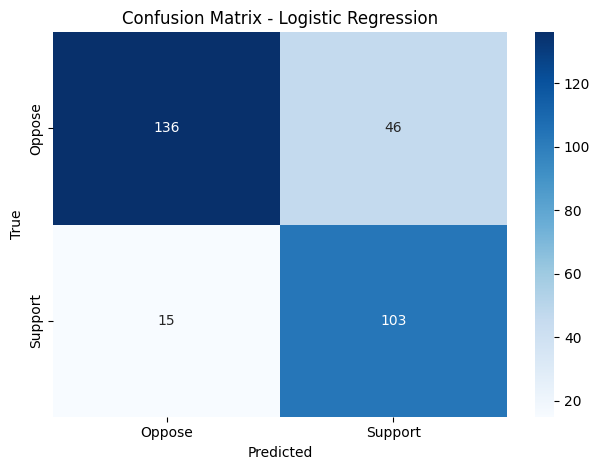

===== Linear SVM =====
Accuracy:  0.7867
Precision: 0.6776
Recall:    0.8729
F1-Score:  0.7630



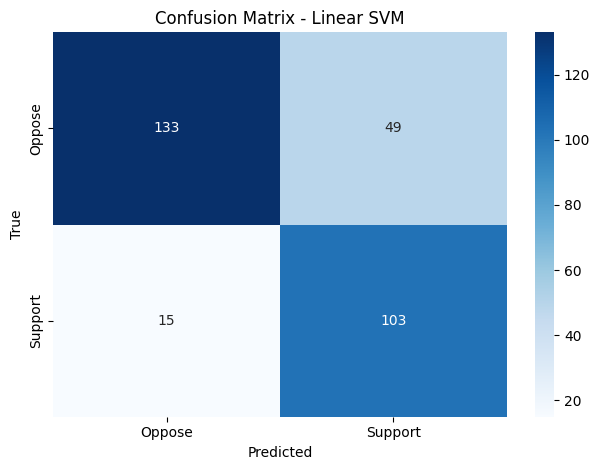

,Accuracy,Precision,Recall,F1
Logistic Regression,0.796667,0.691275,0.872881,0.771536
Linear SVM,0.786667,0.677632,0.872881,0.762963


In [25]:

# Evaluation

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    
    print(f"===== {model_name} =====")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}\n")
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Oppose", "Support"],
                yticklabels=["Oppose", "Support"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    
    return acc, precision, recall, f1

#Run evaluation 
lr_metrics = evaluate_model(lr_clf, X_test_tfidf, y_test, "Logistic Regression")
svm_metrics = evaluate_model(svm_clf, X_test_tfidf, y_test, "Linear SVM")

# Compare models
results = pd.DataFrame(
    [lr_metrics, svm_metrics],
    columns=["Accuracy", "Precision", "Recall", "F1"],
    index=["Logistic Regression", "Linear SVM"]
)
display(results)

### Feature Importance

Small interpretability of our baseline Models

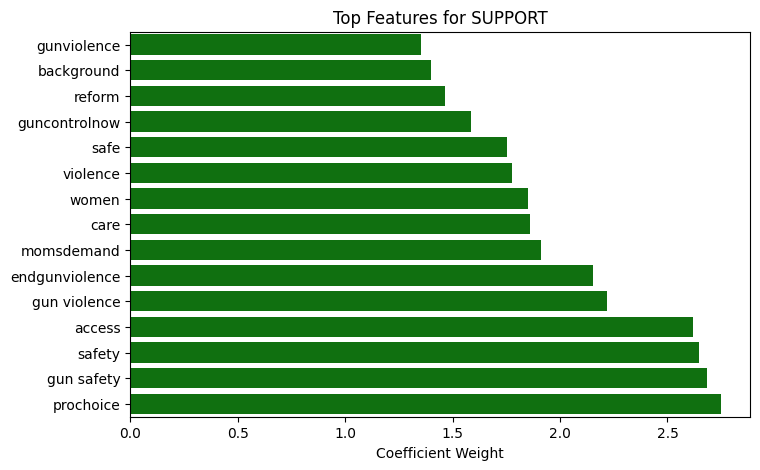

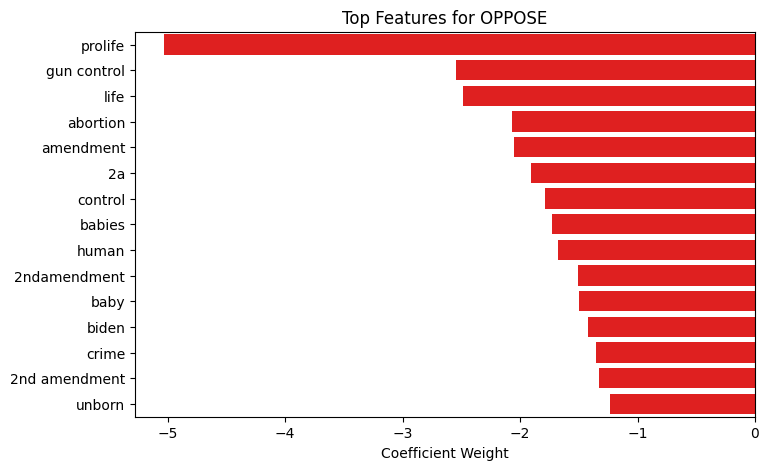

In [26]:
def show_top_features(model, vectorizer, label, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    coef = model.coef_[0]
    if label == 1:
        topn = np.argsort(coef)[-n:]
        color = "green"
        title = "Top Features for SUPPORT"
    else:
        topn = np.argsort(coef)[:n]
        color = "red"
        title = "Top Features for OPPOSE"
    
    top_features = feature_names[topn]
    top_weights = coef[topn]
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_weights, y=top_features, color=color)
    plt.title(title)
    plt.xlabel("Coefficient Weight")
    plt.show()

# Top features for both labels (LR)
show_top_features(lr_clf, tfidf, label=1, n=15)
show_top_features(lr_clf, tfidf, label=0, n=15)


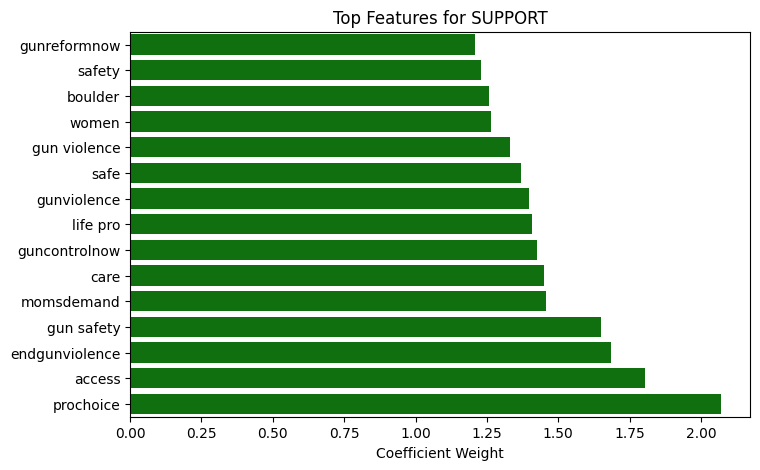

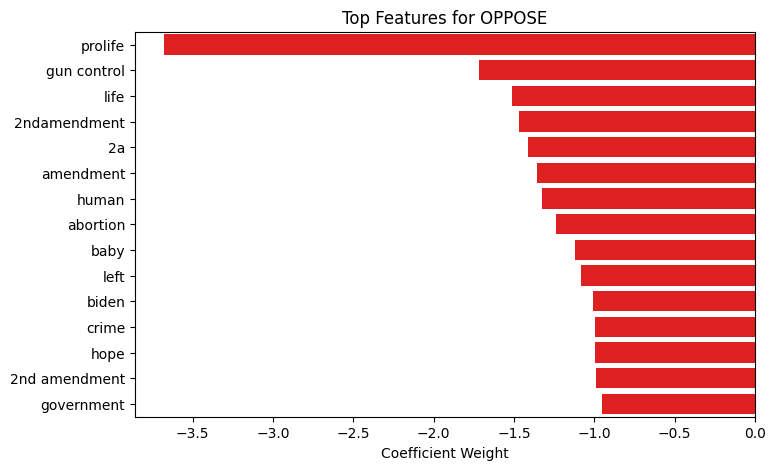

In [27]:
show_top_features(svm_clf, tfidf, label=1, n=15)
show_top_features(svm_clf, tfidf, label=0, n=15)